## GAAIMS: Predicting Multiple Sclerosis from Dynamics of Gait Variability Using an Instrumented Treadmill - A Machine Learning-Based Approach

### Ablation study - Trial and Person generalization ML models 


### Package imports 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import os
from ast import literal_eval
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import xgboost 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from inspect import signature
from scipy import interp
from pyitlib import discrete_random_variable as drv
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.neural_network import MLPClassifier
import itertools
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = 'C:\\Users\\rk4\\Dropbox\\GAIT\\sample_data\\data_export\\'

In [3]:
#Reading the Regress-N dataframe 
regressN_df = pd.read_csv(path+'..\\..\\FinalCodes\\mr_scaled_features_30controlsTrialW.csv', index_col = 0)
regressN_df.reset_index(inplace= True)
print('Regress-N data shape: ', regressN_df.shape)
regressN_df.drop(['index'], axis = 1, inplace = True)
regressN_df = shuffle(regressN_df, random_state = 0)
print('Regress-N data shape: ', regressN_df.shape)  #21 features + PID + Trial ID + Label = 24 features 

Regress-N data shape:  (3230, 25)
Regress-N data shape:  (3230, 24)


## Trial Generalize

In [4]:
#Standardize the data before ML methods 
#Take care that testing set is not used while normalizaing the training set, otherwise the train set indirectly contains 
#information about the test set
def normalize(dataframe, n_type): 
    '''
    Input: dataframe, type of normalization (z-score or min-max)
    '''
    col_names = list(dataframe.columns)
    if (n_type == 'z'): #z-score normalization 
        mean = dataframe.mean()
        sd = dataframe.std()
    else: #min-max normalization
        mean = dataframe.min()
        sd = dataframe.max()-dataframe.min()
    return mean, sd

In [5]:
def evaluate(model, test_features, trueY):
    test_labels = trueY['Label'] #Dropping the PID
    predictions = model.predict(test_features)
    try:
        prediction_prob = model.predict_proba(test_features)[:, 1] #Score of the class with greater label
    except:
        prediction_prob = model.best_estimator_._predict_proba_lr(test_features)[:, 1] #For linear SVM 
    #Stride wise metrics 
    acc = accuracy_score(predictions, test_labels)
    p = precision_score(predictions, test_labels)
    r = recall_score(predictions, test_labels)
    f1 = f1_score(predictions, test_labels)
    auc = roc_auc_score(test_labels, prediction_prob)
    print('Stride-based model performance: ', acc, p, r, f1, auc)
    
    #For computing person wise metrics 
    temp = copy.deepcopy(trueY) #True label for the stride 
    temp['pred'] = predictions #Predicted label for the stride 
    #Correctly slassified strides i.e. 1 if stride is correctly classified and 0 if otherwise
    temp['correct'] = (temp['Label']==temp['pred'])

    #Proportion of correctly classified strides
    proportion_strides_correct = temp.groupby('PID').aggregate({'correct': 'mean'})  
    proportion_strides_correct['True Label'] = trueY.groupby('PID').first() 

    #Label for the person - 0=healthy, 1=MS patient
    proportion_strides_correct['Predicted Label'] = proportion_strides_correct['True Label']*\
    (proportion_strides_correct['correct']>0.5)+(1-proportion_strides_correct['True Label'])*\
    (proportion_strides_correct['correct']<0.5) 

    #Probability of class 1 - MS patient for AUC calculation
    proportion_strides_correct['prob_class1'] = (1-proportion_strides_correct['True Label'])*\
    (1-proportion_strides_correct['correct'])+ proportion_strides_correct['True Label']*proportion_strides_correct['correct'] 
    
    try:
        print (model.best_estimator_)
    except:
        pass
    #Person wise metrics 
    person_acc = accuracy_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label'])
    person_p = precision_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label'])
    person_r = recall_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label'])
    person_f1 = f1_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label'])
    person_auc = roc_auc_score(proportion_strides_correct['True Label'], proportion_strides_correct['prob_class1'])
    print('Person-based model performance: ', person_acc, person_p, person_r, person_f1, person_auc)
    return proportion_strides_correct['prob_class1'], [acc, p, r, f1, auc, person_acc, person_p, person_r, person_f1, person_auc]

In [6]:
def models(trainX, trainY, testX, testY, model_name = 'random_forest'):
    '''
    training set: trainX, testX
    testing set: testX, testY
    model: model_name
    '''
    trainY1 = trainY['Label'] #Dropping the PID
    
    if(model_name == 'random_forest'): #Random Forest
        grid = {
       'n_estimators': [40,45,50],\
       'max_depth' : [15,20,25,None],\
       'class_weight': [None, 'balanced'],\
       'max_features': ['auto','sqrt','log2', None],\
       'min_samples_leaf':[1,2,0.1,0.05]
        }
        rf_grid = RandomForestClassifier(random_state=0)
        grid_search = GridSearchCV(estimator = rf_grid, param_grid = grid, scoring='accuracy', n_jobs = 1, cv = 5)
    
    if(model_name == 'adaboost'): #Adaboost
        ada_grid = AdaBoostClassifier(random_state=0)
        grid = {
        'n_estimators':[50, 75, 100, 125, 150],\
        'learning_rate':[0.01,.1, 1, 1.5, 2]\
        }
        grid_search = GridSearchCV(ada_grid, param_grid = grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name == 'kernel_svm'): #RBF SVM
        svc_grid = SVC(kernel = 'rbf', probability=True, random_state=0)
        grid = {
        'gamma':[0.0001, 0.001, 0.1, 1, 10, ]\
        }
        grid_search = GridSearchCV(svc_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)

    if(model_name == 'gbm'): #GBM
        gbm_grid = GradientBoostingClassifier(random_state=0)
        grid = {
        'learning_rate':[0.15,0.1,0.05], \
        'n_estimators':[50, 100, 150],\
        'max_depth':[2,4,7],\
        'min_samples_split':[2,4], \
        'min_samples_leaf':[1,3],\
        'max_features':[2, 3]\
        }
        grid_search = GridSearchCV(gbm_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name=='xgboost'): #Xgboost
        xgb_grid = xgboost.XGBClassifier(random_state=0)
        grid = {
            'min_child_weight': [1, 5],\
            'gamma': [0.1, 0.5, 1, 1.5, 2],\
            'subsample': [0.6, 0.8, 1.0],\
            'colsample_bytree': [0.6, 0.8, 1.0],\
            'max_depth': [5, 7, 8]
        }
        grid_search = GridSearchCV(xgb_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name == 'knn'): #KNN
        knn_grid = KNeighborsClassifier()
        grid = {
            'n_neighbors': [1, 3, 4, 5, 10],\
            'p': [1, 2, 3, 4, 5]\
        }
        grid_search = GridSearchCV(knn_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
        
    if(model_name == 'decision_tree'): #Decision Tree
        dec_grid = DecisionTreeClassifier(random_state=0)
        grid = {
            'min_samples_split': range(2, 50),\
        }
        grid_search = GridSearchCV(dec_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name == 'linear_svm'): #Linear SVM
        lsvm_grid = LinearSVC(random_state=0)
        grid = {
            'loss': ['hinge','squared_hinge'],\

        }
        grid_search = GridSearchCV(lsvm_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name == 'logistic_regression'): #Logistic regression
        grid_search = LogisticRegression(random_state=0)

    if(model_name == 'mlp'):
        mlp_grid = MLPClassifier(activation='relu', solver='adam', learning_rate = 'adaptive', learning_rate_init=0.001,\
                                                        shuffle=False, max_iter = 200, random_state = 0)
        grid = {
            'hidden_layer_sizes': [(128, 8, 8, 128, 32), (50, 50, 50, 50, 50, 50, 150, 100, 10), 
                                  (50, 50, 50, 50, 50, 60, 30, 20, 50), (50, 50, 50, 50, 50, 150, 10, 60, 150),
                                  (50, 50, 50, 50, 50, 5, 50, 10, 5), (50, 50, 50, 50, 50, 5, 50, 150, 150),
                                  (50, 50, 50, 50, 50, 5, 30, 50, 20), (50, 50, 50, 50, 10, 150, 20, 20, 30),
                                  (50, 50, 50, 50, 30, 150, 100, 20, 100), (50, 50, 50, 50, 30, 5, 100, 20, 100),
                                  (50, 50, 50, 50, 60, 50, 50, 60, 60), (50, 50, 50, 50, 20, 50, 60, 20, 20),
                                  (50, 50, 50, 10, 50, 10, 150, 60, 150), (50, 50, 50, 10, 50, 150, 30, 150, 5),
                                  (50, 50, 50, 10, 50, 20, 150, 5, 10), (50, 50, 50, 10, 150, 50, 20, 20, 100), 
                                  (50, 50, 50, 30, 100, 5, 30, 150, 30), (50, 50, 50, 50, 100, 150, 100, 200), 
                                  (50, 50, 50, 5, 5, 100, 100, 150), (50, 50, 5, 50, 200, 100, 150, 5), 
                                  (50, 50, 5, 5, 200, 100, 50, 30), (50, 50, 5, 10, 5, 200, 200, 10), 
                                  (50, 50, 5, 30, 5, 5, 50, 10), (50, 50, 5, 200, 50, 5, 5, 50), 
                                  (50, 50,50, 5, 5, 100, 100, 150), (5, 5, 5, 5, 5, 100, 50, 5, 50, 50), 
                                  (5, 5, 5, 5, 5, 100, 20, 100, 30, 30), (5, 5, 5, 5, 5, 20, 20, 5, 30, 100), 
                                  (5, 5, 5, 5, 5, 20, 20, 100, 10, 10), (5, 5, 5, 5, 10, 10, 30, 50, 10, 10), 
                                  (5, 5, 5, 5, 10, 100, 30, 30, 30, 10), (5, 5, 5, 5, 10, 100, 50, 10, 50, 10), 
                                  (5, 5, 5, 5, 10, 100, 20, 100, 30, 5), (5, 5, 5, 5, 30, 5, 20, 30, 100, 50), 
                                  (5, 5, 5, 5, 30, 100, 20, 50, 20, 30), (5, 5, 5, 5, 50, 30, 5, 50, 10, 100), 
                                  (21, 21, 7, 84, 21, 84, 84), (21, 21, 5, 42, 42, 7, 42), (21, 84, 7, 7, 7, 84, 5), 
                                  (21, 7, 84, 5, 5, 21, 120), (42, 5, 21, 21, 21, 5, 120), (42, 5, 42, 84, 7, 120, 84), 
                                  (50, 100, 10, 5, 100, 25), (10, 10, 25, 50, 25, 5), (50, 50, 50, 50, 50, 20, 30, 100, 60)]

        }
        grid_search = GridSearchCV(mlp_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
        
    grid_search.fit(trainX, trainY1) #Fitting on the training set to find the optimal hyperparameters 
#     print('best score: ', grid_search.best_score_)
#     print('best_params: ', grid_search.best_params_, grid_search.best_index_)
#     print('Mean cv accuracy on test set:', grid_search.cv_results_['mean_test_score'][grid_search.best_index_])
#     print('Standard deviation on test set:' , grid_search.cv_results_['std_test_score'][grid_search.best_index_])
#     print('Mean cv accuracy on train set:', grid_search.cv_results_['mean_train_score'][grid_search.best_index_])
#     print('Standard deviation on train set:', grid_search.cv_results_['std_train_score'][grid_search.best_index_])
#     print('Test set performance:\n')
    stride_person_metrics = evaluate(grid_search, testX, testY)
    return stride_person_metrics

In [7]:
#RegressN data 
#Make one csv with all 9 algos and 6 data streams and all stride and person based metrics for regressN data only

#Trial W for training 
regressN_trial1 = regressN_df[regressN_df['TrialID']==1]
regressN_trainX = regressN_trial1.drop(['Label', 'PID', 'TrialID'], axis = 1)
regressN_trainY = regressN_trial1[['PID', 'Label']]

#Trial WT for testing 
regressN_trial2 = regressN_df[regressN_df['TrialID']==2]
regressN_testX = regressN_trial2.drop(['Label', 'PID', 'TrialID'], axis = 1)
regressN_testY = regressN_trial2[['PID', 'Label']] #PID to compute person based metrics later 

#Normalize according to z-score standardization
norm_mean, norm_sd = normalize(regressN_trainX, 'z')
regressN_trainX_norm = (regressN_trainX-norm_mean)/norm_sd
regressN_testX_norm = (regressN_testX-norm_mean)/norm_sd

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in training set: ', len(regressN_trainY))
print ('Control strides in training set: ', len(regressN_trainY)-regressN_trainY['Label'].sum())
print('MS strides in training set: ', regressN_trainY['Label'].sum())

#Test Set
print('Strides in test set: ', len(regressN_testY)) 
print ('Control strides in test set: ', len(regressN_testY)-regressN_testY['Label'].sum())
print('MS strides in test set: ', regressN_testY['Label'].sum())
print ('Imbalance ratio (controls:MS)= 1:', regressN_testY['Label'].sum()/(len(regressN_testY)-regressN_testY['Label'].sum()))

Strides in training set:  1654
Control strides in training set:  905
MS strides in training set:  749
Strides in test set:  1576
Control strides in test set:  878
MS strides in test set:  698
Imbalance ratio (controls:MS)= 1: 0.7949886104783599


In [8]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression']
spatial_features = ['stride_length', 'stride_width', 'LeftFPA', 'RightFPA']
temporal_features = ['stride_time', 'swing_time', 'stance_time', 'SS_R', 'DS_L', 'DS_R', 'cadence' ]
spatiotemporal = ['stride_speed', 'walk_ratio']
kinetic_features = ['force_HSR', 'force_MidSSR', 'force_TOR', 'force_HSL', 'force_TOL', 'force_MidSSL', 'Butterfly_x_abs', 'ButterflySQ_x']

datastreams = {'spatial': spatial_features, 'temporal': temporal_features, 'kinetic': kinetic_features, 
        'spatiotemporal': spatial_features+temporal_features+spatiotemporal, 'spatial_kinetic': spatial_features+kinetic_features,\
       'temporal_kinetic':  temporal_features+kinetic_features, 'all': spatial_features+temporal_features+spatiotemporal+\
       kinetic_features}

ablation_columns = list(itertools.product(ml_models,datastreams))
regressN_metrics = pd.DataFrame(columns = ablation_columns) #Dataframe to store accuracies for each ML model for raw data 

('random_forest', 'spatial')
Stride-based model performance:  0.6814720812182741 0.6189111747851003 0.6467065868263473 0.6325036603221084 0.7374927387720203
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Person-based model performance:  0.7428571428571429 0.7058823529411765 0.75 0.7272727272727272 0.8333333333333334
********************************
('random_forest', 'temporal')
Stride-based model performance:  0.6637055837563451 0.6131805157593123 0.622093023255814 0.6176046176046176 0.7365185920071013
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=None, max_leaf_nodes

Stride-based model performance:  0.6395939086294417 0.5859598853868195 0.5944767441860465 0.5901875901875901 0.702803649868482
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)
Person-based model performance:  0.7714285714285715 0.7058823529411765 0.8 0.7500000000000001 0.826797385620915
********************************
('kernel_svm', 'kinetic')
Stride-based model performance:  0.7055837563451777 0.6275071633237822 0.6822429906542056 0.653731343283582 0.7573167070249526
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)
Person-based model performance:  0.7714285714285715 0.5882352941176471 0.9090909090909091 0.7142857142857143 0.9248366013071896
**************

ValueError: max_features must be in (0, n_features]

In [16]:
for col in ablation_columns[21:]:
    print (col)
    model = col[0]
    datastream = datastreams[col[1]]
#     print (regressN_trainX_norm[datastream].head())
    _, stride_person_metrics = models(regressN_trainX_norm[datastream], regressN_trainY, regressN_testX_norm[datastream], regressN_testY, model)
    regressN_metrics[col] = stride_person_metrics
    print ('********************************')

regressN_metrics.index = ['stride_accuracy', 'stride_precision', 'stride_recall', 'stride_F1', 'stride_AUC', 'person_accuracy', 
                     'person_precision', 'person_recall', 'person_F1', 'person_AUC']  
regressN_metrics.to_csv(path+'..//trial_generalize//trial_generalize_ablation_study_regressN.csv')

('gbm', 'spatial')
Stride-based model performance:  0.6459390862944162 0.5659025787965616 0.6076923076923076 0.586053412462908 0.7134507313443552
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=7,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=3, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)
Person-based model performance:  0.7142857142857143 0.5882352941176471 0.7692307692307693 0.6666666666666667 0.7973856209150326
********************************
('gbm', 'temporal')
Stride-based model performance:  0.6681472081218274 0.5859598853868195 0.6360808709175739 0.6099925428784488 0.7359001638263571
GradientBoostingClassifier(criterion='friedman_mse', init=None,
            

Stride-based model performance:  0.7715736040609137 0.671919770773639 0.7816666666666666 0.7226502311248073 0.8527814582503868
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, gamma=0.1,
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.6, verbosity=1)
Person-based model performance:  0.8571428571428571 0.7058823529411765 1.0 0.8275862068965517 0.9640522875816994
********************************
('xgboost', 'temporal_kinetic')
Stride-based model performance:  0.7557106598984772 0.6747851002865329 0.7488076311605724 0.7098718914845517 0.8503175359471579
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, gamma=0.1,
    

Stride-based model performance:  0.7036802030456852 0.6217765042979942 0.6813186813186813 0.6501872659176029 0.7002418233677739
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')
Person-based model performance:  0.8285714285714286 0.7058823529411765 0.9230769230769231 0.8000000000000002 0.9248366013071896
********************************
('decision_tree', 'all')
Stride-based model performance:  0.7493654822335025 0.6833810888252149 0.7327188940092166 0.7071905114899925 0.7654288856544242
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_sam

In [17]:
regressN_metrics

,"(random_forest, spatial)","(random_forest, temporal)","(random_forest, kinetic)","(random_forest, spatiotemporal)","(random_forest, spatial_kinetic)","(random_forest, temporal_kinetic)","(random_forest, all)","(adaboost, spatial)","(adaboost, temporal)","(adaboost, kinetic)",...,"(linear_svm, spatial_kinetic)","(linear_svm, temporal_kinetic)","(linear_svm, all)","(logistic_regression, spatial)","(logistic_regression, temporal)","(logistic_regression, kinetic)","(logistic_regression, spatiotemporal)","(logistic_regression, spatial_kinetic)","(logistic_regression, temporal_kinetic)","(logistic_regression, all)"
stride_accuracy,0.681472,0.663706,0.707487,0.750000,0.779822,0.750000,0.784898,0.649746,0.644670,0.682741,...,0.664340,0.663071,0.728426,0.571066,0.592005,0.663706,0.647843,0.669416,0.645305,0.727157
stride_precision,0.618911,0.613181,0.590258,0.690544,0.656160,0.666189,0.686246,0.494269,0.518625,0.507163,...,0.489971,0.444126,0.604585,0.345272,0.316619,0.494269,0.411175,0.494269,0.444126,0.594556
stride_recall,0.646707,0.622093,0.701874,0.730303,0.810619,0.742812,0.799666,0.634191,0.617747,0.694118,...,0.664078,0.684327,0.735192,0.523913,0.571059,0.660920,0.665893,0.672515,0.644491,0.738434
stride_F1,0.632504,0.617605,0.641245,0.709867,0.725257,0.702417,0.738628,0.555556,0.563863,0.586093,...,0.563891,0.538662,0.663522,0.416235,0.407373,0.565574,0.508415,0.569777,0.525869,0.658730
stride_AUC,0.737493,0.736519,0.793717,0.833982,0.858714,0.834336,0.876800,0.676917,0.682898,0.759152,...,0.693038,0.696621,0.809718,0.572175,0.561301,0.703256,0.699215,0.695595,0.683907,0.806809
person_accuracy,0.742857,0.800000,0.742857,0.914286,0.885714,0.857143,0.828571,0.685714,0.800000,0.742857,...,0.742857,0.714286,0.800000,0.571429,0.657143,0.657143,0.685714,0.685714,0.771429,0.771429
person_precision,0.705882,0.764706,0.588235,0.882353,0.764706,0.764706,0.647059,0.529412,0.647059,0.470588,...,0.529412,0.411765,0.647059,0.352941,0.411765,0.411765,0.411765,0.529412,0.529412,0.588235
person_recall,0.750000,0.812500,0.833333,0.937500,1.000000,0.928571,1.000000,0.750000,0.916667,1.000000,...,0.900000,1.000000,0.916667,0.600000,0.777778,0.777778,0.875000,0.750000,1.000000,0.909091
person_F1,0.727273,0.787879,0.689655,0.909091,0.866667,0.838710,0.785714,0.620690,0.758621,0.640000,...,0.666667,0.583333,0.758621,0.444444,0.538462,0.538462,0.560000,0.620690,0.692308,0.714286
person_AUC,0.833333,0.869281,0.901961,0.915033,0.934641,0.967320,0.970588,0.771242,0.856209,0.862745,...,0.736928,0.767974,0.872549,0.594771,0.627451,0.849673,0.766340,0.736928,0.754902,0.856209


In [35]:
regressN_metrics[list(itertools.product(ml_models,['temporal_kinetic']))]

,"(random_forest, temporal_kinetic)","(adaboost, temporal_kinetic)","(kernel_svm, temporal_kinetic)","(gbm, temporal_kinetic)","(xgboost, temporal_kinetic)","(knn, temporal_kinetic)","(decision_tree, temporal_kinetic)","(linear_svm, temporal_kinetic)","(logistic_regression, temporal_kinetic)"
stride_accuracy,0.750000,0.716371,0.753173,0.751269,0.755711,0.736041,0.703680,0.663071,0.645305
stride_precision,0.666189,0.626074,0.733524,0.669054,0.674785,0.679083,0.621777,0.444126,0.444126
stride_recall,0.742812,0.701445,0.716084,0.743631,0.748808,0.711712,0.681319,0.684327,0.644491
stride_F1,0.702417,0.661620,0.724699,0.704374,0.709872,0.695015,0.650187,0.538662,0.525869
stride_AUC,0.834336,0.796997,0.836046,0.841395,0.850318,0.814416,0.700242,0.696621,0.683907
person_accuracy,0.857143,0.800000,0.885714,0.857143,0.885714,0.857143,0.828571,0.714286,0.771429
person_precision,0.764706,0.647059,0.941176,0.764706,0.823529,0.823529,0.705882,0.411765,0.529412
person_recall,0.928571,0.916667,0.842105,0.928571,0.933333,0.875000,0.923077,1.000000,1.000000
person_F1,0.838710,0.758621,0.888889,0.838710,0.875000,0.848485,0.800000,0.583333,0.692308
person_AUC,0.967320,0.937908,0.950980,0.964052,0.970588,0.954248,0.924837,0.767974,0.754902


In [41]:
model = 'gbm'
datastream = datastreams['spatiotemporal']
print (models(regressN_trainX_norm[datastream], regressN_trainY, regressN_testX_norm[datastream], regressN_testY, model))

Stride-based model performance:  0.7614213197969543 0.7148997134670487 0.7381656804733728 0.7263464337700145 0.8481636436026134
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features=2, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=3, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)
Person-based model performance:  0.9142857142857143 0.8823529411764706 0.9375 0.9090909090909091 0.9542483660130718
(PID
200    0.155556
201    0.205882
202    0.270270
203    0.047619
204    0.053571
205    0.303571
206    0.057692
207    0.153846
208    0.191489
209    0.214286
210    0.350877
211    0.068182
214    0.050847
215    0.294118
216    0.277778
217    0.000000
218    0.680000
219    0.22641

### Adding MLP to the ablation study

In [50]:
regressN_metrics = pd.read_csv(path+'..//trial_generalize//trial_generalize_ablation_study_regressN.csv')
regressN_metrics.index = regressN_metrics['Unnamed: 0']
regressN_metrics.drop('Unnamed: 0', axis = 1, inplace = True)

In [51]:
regressN_metrics

,"('random_forest', 'spatial')","('random_forest', 'temporal')","('random_forest', 'kinetic')","('random_forest', 'spatiotemporal')","('random_forest', 'spatial_kinetic')","('random_forest', 'temporal_kinetic')","('random_forest', 'all')","('adaboost', 'spatial')","('adaboost', 'temporal')","('adaboost', 'kinetic')",...,"('linear_svm', 'spatial_kinetic')","('linear_svm', 'temporal_kinetic')","('linear_svm', 'all')","('logistic_regression', 'spatial')","('logistic_regression', 'temporal')","('logistic_regression', 'kinetic')","('logistic_regression', 'spatiotemporal')","('logistic_regression', 'spatial_kinetic')","('logistic_regression', 'temporal_kinetic')","('logistic_regression', 'all')"
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
stride_accuracy,0.681472,0.663706,0.707487,0.750000,0.779822,0.750000,0.784898,0.649746,0.644670,0.682741,...,0.664340,0.663071,0.728426,0.571066,0.592005,0.663706,0.647843,0.669416,0.645305,0.727157
stride_precision,0.618911,0.613181,0.590258,0.690544,0.656160,0.666189,0.686246,0.494269,0.518625,0.507163,...,0.489971,0.444126,0.604585,0.345272,0.316619,0.494269,0.411175,0.494269,0.444126,0.594556
stride_recall,0.646707,0.622093,0.701874,0.730303,0.810619,0.742812,0.799666,0.634191,0.617747,0.694118,...,0.664078,0.684327,0.735192,0.523913,0.571059,0.660920,0.665893,0.672515,0.644491,0.738434
stride_F1,0.632504,0.617605,0.641245,0.709867,0.725257,0.702417,0.738628,0.555556,0.563863,0.586093,...,0.563891,0.538662,0.663522,0.416235,0.407373,0.565574,0.508415,0.569777,0.525869,0.658730
stride_AUC,0.737493,0.736519,0.793717,0.833982,0.858714,0.834336,0.876800,0.676917,0.682898,0.759152,...,0.693038,0.696621,0.809718,0.572175,0.561301,0.703256,0.699215,0.695595,0.683907,0.806809
person_accuracy,0.742857,0.800000,0.742857,0.914286,0.885714,0.857143,0.828571,0.685714,0.800000,0.742857,...,0.742857,0.714286,0.800000,0.571429,0.657143,0.657143,0.685714,0.685714,0.771429,0.771429
person_precision,0.705882,0.764706,0.588235,0.882353,0.764706,0.764706,0.647059,0.529412,0.647059,0.470588,...,0.529412,0.411765,0.647059,0.352941,0.411765,0.411765,0.411765,0.529412,0.529412,0.588235
person_recall,0.750000,0.812500,0.833333,0.937500,1.000000,0.928571,1.000000,0.750000,0.916667,1.000000,...,0.900000,1.000000,0.916667,0.600000,0.777778,0.777778,0.875000,0.750000,1.000000,0.909091
person_F1,0.727273,0.787879,0.689655,0.909091,0.866667,0.838710,0.785714,0.620690,0.758621,0.640000,...,0.666667,0.583333,0.758621,0.444444,0.538462,0.538462,0.560000,0.620690,0.692308,0.714286


In [53]:
regressN_metrics.columns = [literal_eval(regressN_metrics.loc['person_accuracy'].index[idx]) for idx in range(len(regressN_metrics.loc['person_accuracy'].index))]

In [6]:
mlp_model = ['mlp']
spatial_features = ['stride_length', 'stride_width', 'LeftFPA', 'RightFPA']
temporal_features = ['stride_time', 'swing_time', 'stance_time', 'SS_R', 'DS_L', 'DS_R', 'cadence' ]
spatiotemporal = ['stride_speed', 'walk_ratio']
kinetic_features = ['force_HSR', 'force_MidSSR', 'force_TOR', 'force_HSL', 'force_TOL', 'force_MidSSL', 'Butterfly_x_abs', 'ButterflySQ_x']

datastreams = {'spatial': spatial_features, 'temporal': temporal_features, 'kinetic': kinetic_features, 
        'spatiotemporal': spatial_features+temporal_features+spatiotemporal, 'spatial_kinetic': spatial_features+kinetic_features,\
       'temporal_kinetic':  temporal_features+kinetic_features, 'all': spatial_features+temporal_features+spatiotemporal+\
       kinetic_features}

ablation_columns2 = list(itertools.product(mlp_model,datastreams))

In [55]:
ablation_columns2

[('mlp', 'spatial'),
 ('mlp', 'temporal'),
 ('mlp', 'kinetic'),
 ('mlp', 'spatiotemporal'),
 ('mlp', 'spatial_kinetic'),
 ('mlp', 'temporal_kinetic'),
 ('mlp', 'all')]

In [112]:
for col in ablation_columns2:
    print (col)
    model = col[0]
    datastream = datastreams[col[1]]
#     print (regressN_trainX_norm[datastream].head())
    _, stride_person_metrics = models(regressN_trainX_norm[datastream], regressN_trainY, regressN_testX_norm[datastream], regressN_testY, model)
    regressN_metrics[col] = stride_person_metrics
    print ('********************************')

('mlp', 'spatial')
Stride-based model performance:  0.6770304568527918 0.5558739255014327 0.6609880749574105 0.6038910505836576 0.7234810163761087
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50, 50, 50, 10, 150, 20, 20, 30),
       learning_rate='adaptive', learning_rate_init=0.001, max_iter=200,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5, random_state=0,
       shuffle=False, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
Person-based model performance:  0.7142857142857143 0.5294117647058824 0.8181818181818182 0.6428571428571428 0.8366013071895424
********************************
('mlp', 'temporal')
Stride-based model performance:  0.6833756345177665 0.6232091690544412 0.6482861400894188 0.6355003652300949 0.763205644503332
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
    

In [118]:
regressN_metrics.to_csv(path+'..//trial_generalize//trial_generalize_ablation_study_regressN_MLPincluded.csv')

In [23]:
regressN_metrics = pd.read_csv(path+'..//trial_generalize//trial_generalize_ablation_study_regressN_MLPincluded.csv')
regressN_metrics.index = regressN_metrics['Unnamed: 0']
regressN_metrics.drop('Unnamed: 0', axis = 1, inplace = True)

regressN_metrics.columns = [literal_eval(regressN_metrics.loc['person_accuracy'].index[idx]) for idx in range(len(regressN_metrics.loc['person_accuracy'].index))]

In [24]:
regressN_metrics

,"(random_forest, spatial)","(random_forest, temporal)","(random_forest, kinetic)","(random_forest, spatiotemporal)","(random_forest, spatial_kinetic)","(random_forest, temporal_kinetic)","(random_forest, all)","(adaboost, spatial)","(adaboost, temporal)","(adaboost, kinetic)",...,"(logistic_regression, spatial_kinetic)","(logistic_regression, temporal_kinetic)","(logistic_regression, all)","(mlp, all)","(mlp, spatial)","(mlp, temporal)","(mlp, kinetic)","(mlp, spatiotemporal)","(mlp, spatial_kinetic)","(mlp, temporal_kinetic)"
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
stride_accuracy,0.681472,0.663706,0.707487,0.750000,0.779822,0.750000,0.784898,0.649746,0.644670,0.682741,...,0.669416,0.645305,0.727157,0.802030,0.677030,0.683376,0.730330,0.777284,0.772843,0.783629
stride_precision,0.618911,0.613181,0.590258,0.690544,0.656160,0.666189,0.686246,0.494269,0.518625,0.507163,...,0.494269,0.444126,0.594556,0.792264,0.555874,0.623209,0.717765,0.878223,0.818052,0.742120
stride_recall,0.646707,0.622093,0.701874,0.730303,0.810619,0.742812,0.799666,0.634191,0.617747,0.694118,...,0.672515,0.644491,0.738434,0.768056,0.660988,0.648286,0.687243,0.697383,0.711970,0.762887
stride_F1,0.632504,0.617605,0.641245,0.709867,0.725257,0.702417,0.738628,0.555556,0.563863,0.586093,...,0.569777,0.525869,0.658730,0.779972,0.603891,0.635500,0.702172,0.777425,0.761333,0.752360
stride_AUC,0.737493,0.736519,0.793717,0.833982,0.858714,0.834336,0.876800,0.676917,0.682898,0.759152,...,0.695595,0.683907,0.806809,0.872507,0.723481,0.763206,0.795543,0.879087,0.856809,0.864341
person_accuracy,0.742857,0.800000,0.742857,0.914286,0.885714,0.857143,0.828571,0.685714,0.800000,0.742857,...,0.685714,0.771429,0.771429,0.942857,0.714286,0.771429,0.800000,0.885714,0.885714,0.914286
person_precision,0.705882,0.764706,0.588235,0.882353,0.764706,0.764706,0.647059,0.529412,0.647059,0.470588,...,0.529412,0.529412,0.588235,0.882353,0.529412,0.705882,0.705882,0.941176,0.882353,0.823529
person_recall,0.750000,0.812500,0.833333,0.937500,1.000000,0.928571,1.000000,0.750000,0.916667,1.000000,...,0.750000,1.000000,0.909091,1.000000,0.818182,0.800000,0.857143,0.842105,0.882353,1.000000
person_F1,0.727273,0.787879,0.689655,0.909091,0.866667,0.838710,0.785714,0.620690,0.758621,0.640000,...,0.620690,0.692308,0.714286,0.937500,0.642857,0.750000,0.774194,0.888889,0.882353,0.903226


### Heatmap for person-accuracy for all datastreams and algorithms for cross-task generality

In [27]:
person_accuracy = pd.DataFrame(columns = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp'], index = list(datastreams.keys()))



In [32]:
for idx in range(len(regressN_metrics.columns)):
    x = regressN_metrics.loc['person_accuracy'].index[idx][1]
    y = regressN_metrics.loc['person_accuracy'].index[idx][0]
#     print (regressN_metrics.loc['person_accuracy'][(y, x)])
    person_accuracy.loc[x, y] = regressN_metrics.loc['person_accuracy'][(y, x)]

person_accuracy = person_accuracy.astype(float)

person_accuracy.drop(['knn'], inplace = True, axis = 1)
ml_model_names1 = ['RF','AdaBoost', 'RBF SVM', 'GBM','Xgboost', 'DT',  'LSVM', 'LR', 'MLP']
datasets = ['Spatial', 'Temporal', 'Kinetic', 'Spatiotemporal', 'Spatial+Kinetic', \
       'Temporal+Kinetic', 'All']

In [33]:
person_accuracy.loc['all'] = [0.94, 0.89, 0.94, 0.94, 0.91, 0.80, 0.80, 0.77, 0.89] #Earlier results with all features 

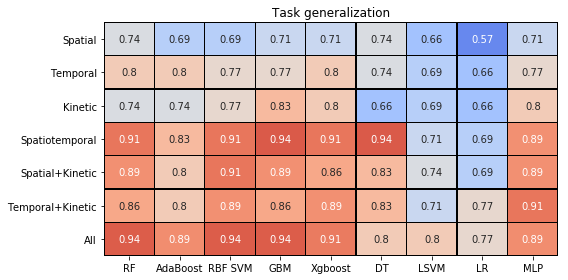

In [34]:
fig, axes = plt.subplots(1, 1, figsize=(8, 4))
sns.heatmap(person_accuracy, vmin=0.5, vmax=1, center = 0.75, cmap="coolwarm", annot=True, linewidths=0.4, linecolor="k", \
            cbar = False, xticklabels=ml_model_names1,  yticklabels=datasets)
plt.title('Task generalization')
plt.tight_layout()
plt.savefig(path + '..//viz//AblationStudy_trial_generalize_heatmap.jpg', dpi = 250)
plt.show()

## People generalize

In [56]:
def evaluate_person_generalize(model, test_features, yoriginal_, ypredicted_):
    best_index = model.cv_results_['mean_test_accuracy'].argmax()
    print('best_params: ', model.cv_results_['params'][best_index])

    #Stride-wise metrics 
    stride_metrics_mean, stride_metrics_std = [], [] #Mean and SD of stride based metrics - Acc, P, R, F1, AUC (in order)
    scores={'accuracy': make_scorer(acc), 'precision':'precision', 'recall':'recall', 'f1': 'f1', 'auc': 'roc_auc'}
    for score in scores:
        stride_metrics_mean.append(model.cv_results_['mean_test_'+score][best_index])
        stride_metrics_std.append(model.cv_results_['std_test_'+score][best_index])
    print('Stride-based model performance (mean): ', stride_metrics_mean)
    print('Stride-based model performance (standard deviation): ', stride_metrics_std)
    n_folds = 7
    person_acc, person_p, person_r, person_f1, person_auc = [], [], [], [], []
    #For ROC curves 
    tpr_list = []
    base_fpr = np.linspace(0, 1, 101)

    for i in range(n_folds):
        #For each fold, there are 2 splits: test and train (in order) and we need to retrieve the index 
        #of only test set for required 5 folds (best index)
        temp = test_features.loc[yoriginal_[(best_index*2*n_folds) + (2*i)].index] #True labels for the test strides in each fold
        temp['pred'] = ypredicted_[(best_index*2*n_folds) + (2*i)] #Predicted labels for the strides in the test set in each fold

        #Correctly classified strides i.e. 1 if stride is correctly classified and 0 if otherwise
        temp['correct'] = (temp['Label']==temp['pred'])

        #Proportion of correctly classified strides
        proportion_strides_correct = temp.groupby('PID').aggregate({'correct': 'mean'})  

        proportion_strides_correct['True Label'] = temp[['PID', 'Label']].groupby('PID').first() 

        #Label for the person - 0=healthy, 1=MS patient
        proportion_strides_correct['Predicted Label'] = proportion_strides_correct['True Label']*\
        (proportion_strides_correct['correct']>0.5)+(1-proportion_strides_correct['True Label'])*\
        (proportion_strides_correct['correct']<0.5) 

        #Probability of class 1 - MS patient for AUC calculation
        proportion_strides_correct['prob_class1'] = (1-proportion_strides_correct['True Label'])*\
        (1-proportion_strides_correct['correct'])+ proportion_strides_correct['True Label']*proportion_strides_correct['correct'] 

        fpr, tpr, _ = roc_curve(proportion_strides_correct['True Label'], proportion_strides_correct['prob_class1'])
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tpr_list.append(tpr)

        #Person wise metrics for each fold 
        person_acc.append(accuracy_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_p.append(precision_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_r.append(recall_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_f1.append(f1_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_auc.append(roc_auc_score(proportion_strides_correct['True Label'], proportion_strides_correct['prob_class1']))

    #Mean and standard deviation for person-based metrics 
    person_means = [np.mean(person_acc), np.mean(person_p), np.mean(person_r), np.mean(person_f1), np.mean(person_auc)]
    person_stds = [np.std(person_acc), np.std(person_p), np.std(person_r), np.std(person_f1), np.std(person_auc)]
    print('Person-based model performance (mean): ', person_means)
    print('Person-based model performance (standard deviation): ', person_stds)

    return tpr_list, [stride_metrics_mean, stride_metrics_std, person_means, person_stds]

In [57]:
def acc(y_true,y_pred):
    global yoriginal, ypredicted
    yoriginal.append(y_true)
    ypredicted.append(y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

In [46]:
#We do not use LDA/QDA since our features are not normally distributed 
def models_person_generalize(X, Y, model_name = 'random_forest'):
    '''
    X, Y, PID groups so that strides of each person are either in training or in testing set
    model: model_name
    '''
    Y_ = Y['Label'] #Dropping the PID
    groups_ = Y['PID']
    gkf = GroupKFold(n_splits=7) 
    scores={'accuracy': make_scorer(acc), 'precision':'precision', 'recall':'recall', 'f1': 'f1', 'auc': 'roc_auc'}
    
    if(model_name == 'random_forest'): #Random Forest
        grid = {
       'randomforestclassifier__n_estimators': [40,45,50],\
       'randomforestclassifier__max_depth' : [15,20,25,None],\
       'randomforestclassifier__class_weight': [None, 'balanced'],\
       'randomforestclassifier__max_features': ['auto','sqrt','log2', None],\
       'randomforestclassifier__min_samples_leaf':[1,2,0.1,0.05]
        }
        #For z-score scaling on training and use calculated coefficients on test set
        rf_grid = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=0))
        grid_search = GridSearchCV(rf_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    
    if(model_name == 'adaboost'): #Adaboost
        ada_grid = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=0))
        grid = {
        'adaboostclassifier__n_estimators':[50, 75, 100, 125, 150],\
        'adaboostclassifier__learning_rate':[0.01,.1, 1, 1.5, 2]\
        }
        grid_search = GridSearchCV(ada_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
        
    if(model_name == 'kernel_svm'): #RBF SVM
        svc_grid = make_pipeline(StandardScaler(), SVC(kernel = 'rbf', probability=True, random_state=0))
        grid = {
        'svc__gamma':[0.0001, 0.001, 0.1, 1, 10, ]\
        }
        grid_search = GridSearchCV(svc_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)

    if(model_name == 'gbm'): #GBM
        gbm_grid = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=0))
        grid = {
        'gradientboostingclassifier__learning_rate':[0.15,0.1,0.05], \
        'gradientboostingclassifier__n_estimators':[50, 100, 150],\
        'gradientboostingclassifier__max_depth':[2,4,7],\
        'gradientboostingclassifier__min_samples_split':[2,4], \
        'gradientboostingclassifier__min_samples_leaf':[1,3],\
        'gradientboostingclassifier__max_features':['auto','sqrt','log2', None],\
        }
        grid_search = GridSearchCV(gbm_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    
    if(model_name=='xgboost'): #Xgboost
        xgb_grid = make_pipeline(StandardScaler(), xgboost.XGBClassifier(random_state=0))
        grid = {
            'xgbclassifier__min_child_weight': [1, 5],\
            'xgbclassifier__gamma': [0.1, 0.5, 1, 1.5, 2],\
            'xgbclassifier__subsample': [0.6, 0.8, 1.0],\
            'xgbclassifier__colsample_bytree': [0.6, 0.8, 1.0],\
            'xgbclassifier__max_depth': [5, 7, 8]
        }
        grid_search = GridSearchCV(xgb_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    
    if(model_name == 'knn'): #KNN
        knn_grid = make_pipeline(StandardScaler(), KNeighborsClassifier())
        grid = {
            'kneighborsclassifier__n_neighbors': [1, 3, 4, 5, 10],\
            'kneighborsclassifier__p': [1, 2, 3, 4, 5]\
        }
        grid_search = GridSearchCV(knn_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
        
    if(model_name == 'decision_tree'): #Decision Tree
        dec_grid = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=0))
        #For z-score scaling on training and use calculated coefficients on test set
        grid = {'decisiontreeclassifier__min_samples_split': range(2, 50)}
        grid_search = GridSearchCV(dec_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)

    if(model_name == 'linear_svm'): #Linear SVM
        lsvm_grid = make_pipeline(StandardScaler(), LinearSVC(random_state=0))
        grid = {
            'linearsvc__loss': ['hinge','squared_hinge'],\

        }
        grid_search = GridSearchCV(lsvm_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    
    if(model_name == 'logistic_regression'): #Logistic regression
        lr_grid = make_pipeline(StandardScaler(), LogisticRegression())
        grid = {
            'logisticregression__random_state': [0]}
            
        grid_search = GridSearchCV(lr_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
        
    if(model_name == 'mlp'):
        mlp_grid = MLPClassifier(activation='relu', solver='adam', learning_rate = 'adaptive', learning_rate_init=0.001,\
                                                        shuffle=False, max_iter = 200, random_state = 0)
        grid = {
            'hidden_layer_sizes':  [(128, 8, 8, 128, 32), (50, 50, 50, 50, 50, 50, 150, 100, 10), 
                                  (50, 50, 50, 50, 50, 60, 30, 20, 50), (50, 50, 50, 50, 50, 150, 10, 60, 150),
                                  (50, 50, 50, 50, 50, 5, 50, 10, 5), (50, 50, 50, 50, 50, 5, 50, 150, 150),
                                  (50, 50, 50, 50, 50, 5, 30, 50, 20), (50, 50, 50, 50, 10, 150, 20, 20, 30),
                                  (50, 50, 50, 50, 30, 150, 100, 20, 100), (50, 50, 50, 50, 30, 5, 100, 20, 100),
                                  (50, 50, 50, 50, 60, 50, 50, 60, 60), (50, 50, 50, 50, 20, 50, 60, 20, 20),
                                  (50, 50, 50, 10, 50, 10, 150, 60, 150), (50, 50, 50, 10, 50, 150, 30, 150, 5),
                                  (50, 50, 50, 10, 50, 20, 150, 5, 10), (50, 50, 50, 10, 150, 50, 20, 20, 100), 
                                  (50, 50, 50, 30, 100, 5, 30, 150, 30), (50, 50, 50, 50, 100, 150, 100, 200), 
                                  (50, 50, 50, 5, 5, 100, 100, 150), (50, 50, 5, 50, 200, 100, 150, 5), 
                                  (50, 50, 5, 5, 200, 100, 50, 30), (50, 50, 5, 10, 5, 200, 200, 10), 
                                  (50, 50, 5, 30, 5, 5, 50, 10), (50, 50, 5, 200, 50, 5, 5, 50), 
                                  (50, 50,50, 5, 5, 100, 100, 150), (5, 5, 5, 5, 5, 100, 50, 5, 50, 50), 
                                  (5, 5, 5, 5, 5, 100, 20, 100, 30, 30), (5, 5, 5, 5, 5, 20, 20, 5, 30, 100), 
                                  (5, 5, 5, 5, 5, 20, 20, 100, 10, 10), (5, 5, 5, 5, 10, 10, 30, 50, 10, 10), 
                                  (5, 5, 5, 5, 10, 100, 30, 30, 30, 10), (5, 5, 5, 5, 10, 100, 50, 10, 50, 10), 
                                  (5, 5, 5, 5, 10, 100, 20, 100, 30, 5), (5, 5, 5, 5, 30, 5, 20, 30, 100, 50), 
                                  (5, 5, 5, 5, 30, 100, 20, 50, 20, 30), (5, 5, 5, 5, 50, 30, 5, 50, 10, 100), 
                                  (21, 21, 7, 84, 21, 84, 84), (21, 21, 5, 42, 42, 7, 42), (21, 84, 7, 7, 7, 84, 5), 
                                  (21, 7, 84, 5, 5, 21, 120), (42, 5, 21, 21, 21, 5, 120), (42, 5, 42, 84, 7, 120, 84), 
                                  (50, 100, 10, 5, 100, 25), (10, 10, 25, 50, 25, 5), (50, 50, 50, 50, 50, 20, 30, 100, 60)]

        }
        grid_search = GridSearchCV(mlp_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
        
    grid_search.fit(X, Y_, groups=groups_) #Fitting on the training set to find the optimal hyperparameters 
    tpr_list, stride_person_metrics = evaluate_person_generalize(grid_search, Y, yoriginal, ypredicted)
    return tpr_list, stride_person_metrics

In [59]:
#CV for people generalize so no train-test split
X_regressN = regressN_df.drop(['Label', 'PID', 'TrialID'], axis = 1)
Y_regressN = regressN_df[['PID', 'Label']] #PID to compute person based metrics later 

In [55]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 'logistic_regression', 'mlp']
spatial_features = ['stride_length', 'stride_width', 'LeftFPA', 'RightFPA']
temporal_features = ['stride_time', 'swing_time', 'stance_time', 'SS_R', 'DS_L', 'DS_R', 'cadence' ]
spatiotemporal = ['stride_speed', 'walk_ratio']
kinetic_features = ['force_HSR', 'force_MidSSR', 'force_TOR', 'force_HSL', 'force_TOL', 'force_MidSSL', 'Butterfly_x_abs', 'ButterflySQ_x']

datastreams = {'spatial': spatial_features, 'temporal': temporal_features, 'kinetic': kinetic_features, 
        'spatiotemporal': spatial_features+temporal_features+spatiotemporal, 'spatial_kinetic': spatial_features+kinetic_features,\
       'temporal_kinetic':  temporal_features+kinetic_features, 'all': spatial_features+temporal_features+spatiotemporal+\
       kinetic_features}

ablation_columns = list(itertools.product(ml_models,datastreams))
regressN_metrics = pd.DataFrame(columns = ablation_columns) #Dataframe to store accuracies for each ML model for raw data 

for col in ablation_columns:
    print (col)
    model = col[0]
    datastream = datastreams[col[1]]
    yoriginal = []
    ypredicted = []
#     print (regressN_trainX_norm[datastream].head())
    _, stride_person_metrics = models_person_generalize(X_regressN[datastream], Y_regressN, model)
    regressN_metrics[col] = sum(stride_person_metrics, [])
    print ('********************************')
regressN_metrics = pd.DataFrame(columns = ablation_columns) #Dataframe to store accuracies for each ML model for raw data 

regressN_metrics.index = ['stride_mean_accuracy', 'stride_mean_precision', 'stride_mean_recall', 'stride_mean_F1', \
                     'stride_mean_AUC', 'stride_std_accuracy', 'stride_std_precision', 'stride_std_recall', 'stride_std_F1', \
                     'stride_std_AUC','person_mean_accuracy', 'person_mean_precision', 'person_mean_recall', 'person_mean_F1',\
                     'person_mean_AUC', 'person_std_accuracy', 'person_std_precision', 'person_std_recall', 'person_std_F1',\
                     'person_std_AUC']  
regressN_metrics.to_csv('person_generalize_ablation_study_regressN_MLP_added.csv')

('random_forest', 'spatial')
best_params:  {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 0.05, 'randomforestclassifier__n_estimators': 50}
Stride-based model performance (mean):  [0.4953560371517028, 0.42629086162799557, 0.4280346247481992, 0.3905652529872241, 0.4960235132780273]
Stride-based model performance (standard deviation):  [0.09689400533170178, 0.2817311963185679, 0.26464916009381395, 0.2104823600819429, 0.18478989785776276]
Person-based model performance (mean):  [0.48571428571428577, 0.369047619047619, 0.4523809523809524, 0.3714285714285714, 0.6904761904761905]
Person-based model performance (standard deviation):  [0.18070158058105024, 0.32076651393589234, 0.329914439536929, 0.2657296462534039, 0.2586376307428623]
********************************
('random_forest', 'temporal')
best_params:  {'randomforestclassifier__class_weight': None, 'r

best_params:  {'adaboostclassifier__learning_rate': 2, 'adaboostclassifier__n_estimators': 100}
Stride-based model performance (mean):  [0.5541795665634675, 0.4078343389580117, 0.5636710903507772, 0.4667761135423143, 0.47581387120428903]
Stride-based model performance (standard deviation):  [0.14330577097501532, 0.2811991362469894, 0.36286522239752117, 0.31006509126955306, 0.14928238830611354]
Person-based model performance (mean):  [0.5714285714285714, 0.5238095238095238, 0.4238095238095238, 0.4650793650793651, 0.4761904761904762]
Person-based model performance (standard deviation):  [0.1665986255670086, 0.3824375810525955, 0.30064179271742086, 0.3317650180638163, 0.3610893068595976]
********************************
('adaboost', 'spatial_kinetic')
best_params:  {'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 50}
Stride-based model performance (mean):  [0.6191950464396285, 0.6138759150060287, 0.44225337522465946, 0.48231207828018213, 0.649722692721142]
St

best_params:  {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassifier__max_features': 'sqrt', 'gradientboostingclassifier__min_samples_leaf': 3, 'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__n_estimators': 150}
Stride-based model performance (mean):  [0.5284829721362229, 0.5027942292003512, 0.43136994582067273, 0.44243805787221097, 0.5598765550915005]
Stride-based model performance (standard deviation):  [0.10229697570104121, 0.25418372696806846, 0.09247974187564251, 0.14031407679272426, 0.1573112364784172]
Person-based model performance (mean):  [0.5428571428571428, 0.40476190476190477, 0.6071428571428571, 0.4619047619047619, 0.6666666666666667]
Person-based model performance (standard deviation):  [0.20603150145508511, 0.17496355305594127, 0.374574588632197, 0.22707845747745453, 0.25197631533948484]
********************************
('gbm', 'kinetic')
best_params:  {'gradientboostingc

best_params:  {'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 1.5, 'xgbclassifier__max_depth': 8, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__subsample': 0.8}
Stride-based model performance (mean):  [0.5040247678018576, 0.4650896887819661, 0.4000655806579525, 0.4006952120134143, 0.526121477375775]
Stride-based model performance (standard deviation):  [0.06866497166745082, 0.2494715976842748, 0.1410704435783097, 0.1301096741795159, 0.15123095865711494]
Person-based model performance (mean):  [0.6, 0.4404761904761905, 0.6666666666666667, 0.4809523809523809, 0.6190476190476192]
Person-based model performance (standard deviation):  [0.1511857892036909, 0.284222294912222, 0.3450327796711771, 0.23152849106939463, 0.26298478612350623]
********************************
('xgboost', 'spatial_kinetic')
best_params:  {'xgbclassifier__colsample_bytree': 0.6, 'xgbclassifier__gamma': 2, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__subs

best_params:  {'decisiontreeclassifier__min_samples_split': 44}
Stride-based model performance (mean):  [0.5136222910216718, 0.4702017344705088, 0.48849871472999584, 0.45254786159093274, 0.5236028013689239]
Stride-based model performance (standard deviation):  [0.04411135319993852, 0.19426081100423528, 0.10897588804615006, 0.0975055816256372, 0.0894786613653128]
Person-based model performance (mean):  [0.5142857142857142, 0.5833333333333334, 0.5476190476190476, 0.5047619047619046, 0.6190476190476192]
Person-based model performance (standard deviation):  [0.09897433186107868, 0.27817432013209337, 0.1934294858246657, 0.11045155718803047, 0.17169291787923757]
********************************
('decision_tree', 'temporal')
best_params:  {'decisiontreeclassifier__min_samples_split': 28}
Stride-based model performance (mean):  [0.5609907120743034, 0.5225354968701255, 0.47376812561315895, 0.4781333265245685, 0.5689123592903736]
Stride-based model performance (standard deviation):  [0.073658908

best_params:  {'linearsvc__loss': 'hinge'}
Stride-based model performance (mean):  [0.5377708978328173, 0.5502806580439287, 0.3806766330661078, 0.41455626236278287, 0.5573511947145726]
Stride-based model performance (standard deviation):  [0.1938809865555458, 0.3096517331501096, 0.21802199039490255, 0.2250511802513076, 0.2529655169670133]
Person-based model performance (mean):  [0.5428571428571428, 0.4404761904761905, 0.6547619047619048, 0.4714285714285714, 0.6071428571428571]
Person-based model performance (standard deviation):  [0.25555062599997597, 0.28422229491222195, 0.4092884151826449, 0.28531718436086173, 0.2386897339971836]
********************************
('linear_svm', 'all')
best_params:  {'linearsvc__loss': 'squared_hinge'}
Stride-based model performance (mean):  [0.5492260061919505, 0.4965196043505058, 0.40238346320694723, 0.40402807208307895, 0.5734596819929892]
Stride-based model performance (standard deviation):  [0.16088368400875477, 0.3205357488476082, 0.2887926131437

best_params:  {'hidden_layer_sizes': (128, 8, 8, 128, 32)}
Stride-based model performance (mean):  [0.4842105263157895, 0.4455644565131331, 0.4065553301636595, 0.3862233400247485, 0.526464988110498]
Stride-based model performance (standard deviation):  [0.03409814691434081, 0.2188362320229303, 0.16510516686843846, 0.1014240936029978, 0.09675274088639481]
Person-based model performance (mean):  [0.42857142857142855, 0.2857142857142857, 0.19047619047619047, 0.22380952380952382, 0.6309523809523808]
Person-based model performance (standard deviation):  [0.12777531299998798, 0.3642156795423418, 0.2258769757263128, 0.26827744801911, 0.17737695744942072]
********************************
('mlp', 'spatial_kinetic')
best_params:  {'hidden_layer_sizes': (128, 8, 8, 128, 32)}
Stride-based model performance (mean):  [0.4758513931888545, 0.42935019099745164, 0.3499496739388593, 0.34196069776032983, 0.49126901027909115]
Stride-based model performance (standard deviation):  [0.04636367847452617, 0.218

In [7]:
ml_models = ['mlp']
#['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 'logistic_regression', 'mlp']
spatial_features = ['stride_length', 'stride_width', 'LeftFPA', 'RightFPA']
temporal_features = ['stride_time', 'swing_time', 'stance_time', 'SS_R', 'DS_L', 'DS_R', 'cadence' ]
spatiotemporal = ['stride_speed', 'walk_ratio']
kinetic_features = ['force_HSR', 'force_MidSSR', 'force_TOR', 'force_HSL', 'force_TOL', 'force_MidSSL', 'Butterfly_x_abs', 'ButterflySQ_x']

datastreams = {'spatial': spatial_features, 'temporal': temporal_features, 'kinetic': kinetic_features, 
        'spatiotemporal': spatial_features+temporal_features+spatiotemporal, 'spatial_kinetic': spatial_features+kinetic_features,\
       'temporal_kinetic':  temporal_features+kinetic_features, 'all': spatial_features+temporal_features+spatiotemporal+\
       kinetic_features}

ablation_columns = list(itertools.product(ml_models,datastreams))
regressN_metrics = pd.DataFrame(columns = ablation_columns) #Dataframe to store accuracies for each ML model for raw data 

for col in ablation_columns:
    print (col)
    model = col[0]
    datastream = datastreams[col[1]]
    yoriginal = []
    ypredicted = []
#     print (regressN_trainX_norm[datastream].head())
    _, stride_person_metrics = models_person_generalize(X_regressN[datastream], Y_regressN, model)
    regressN_metrics[col] = sum(stride_person_metrics, [])
    print ('********************************')

regressN_metrics.index = ['stride_mean_accuracy', 'stride_mean_precision', 'stride_mean_recall', 'stride_mean_F1', \
                     'stride_mean_AUC', 'stride_std_accuracy', 'stride_std_precision', 'stride_std_recall', 'stride_std_F1', \
                     'stride_std_AUC','person_mean_accuracy', 'person_mean_precision', 'person_mean_recall', 'person_mean_F1',\
                     'person_mean_AUC', 'person_std_accuracy', 'person_std_precision', 'person_std_recall', 'person_std_F1',\
                     'person_std_AUC']  
regressN_metrics.to_csv('person_generalize_ablation_study_regressN_MLP_added_onlyMLPresults.csv')

('mlp', 'spatial')
best_params:  {'hidden_layer_sizes': (21, 21, 7, 84, 21, 84, 84)}
Stride-based model performance (mean):  [0.5043343653250774, 0.4738695407387358, 0.34365945906394213, 0.3666034764550636, 0.48844118517905266]
Stride-based model performance (standard deviation):  [0.07392809702373979, 0.24577454209141603, 0.09892134045546222, 0.0971262560134371, 0.09070102124715118]
Person-based model performance (mean):  [0.48571428571428565, 0.29761904761904756, 0.40476190476190477, 0.3142857142857142, 0.5595238095238095]
Person-based model performance (standard deviation):  [0.09897433186107868, 0.20824828195876072, 0.31943828249996997, 0.20303814862216996, 0.254773030464675]
********************************
('mlp', 'temporal')
best_params:  {'hidden_layer_sizes': (5, 5, 5, 5, 30, 5, 20, 30, 100, 50)}
Stride-based model performance (mean):  [0.5879256965944273, 0.580275669917507, 0.20772567265773093, 0.3020591586589869, 0.5582176777956378]
Stride-based model performance (standard d

In [11]:
regressN_metrics = pd.DataFrame(columns = ablation_columns) #Dataframe to store accuracies for each ML model for raw data 
ml_models = ['mlp']
#['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 'logistic_regression', 'mlp']
spatial_features = ['stride_length', 'stride_width', 'LeftFPA', 'RightFPA']
temporal_features = ['stride_time', 'swing_time', 'stance_time', 'SS_R', 'DS_L', 'DS_R', 'cadence' ]
spatiotemporal = ['stride_speed', 'walk_ratio']
kinetic_features = ['force_HSR', 'force_MidSSR', 'force_TOR', 'force_HSL', 'force_TOL', 'force_MidSSL', 'Butterfly_x_abs', 'ButterflySQ_x']

datastreams = {'spatial': spatial_features, 'temporal': temporal_features, 'kinetic': kinetic_features, 
        'spatiotemporal': spatial_features+temporal_features+spatiotemporal, 'spatial_kinetic': spatial_features+kinetic_features,\
       'temporal_kinetic':  temporal_features+kinetic_features, 'all': spatial_features+temporal_features+spatiotemporal+\
       kinetic_features}

ablation_columns = list(itertools.product(ml_models,datastreams))
regressN_metrics = pd.DataFrame(columns = ablation_columns) #Dataframe to store accuracies for each ML model for raw data 

for col in ablation_columns:
    print (col)
    model = col[0]
    datastream = datastreams[col[1]]
    yoriginal = []
    ypredicted = []
#     print (regressN_trainX_norm[datastream].head())
    _, stride_person_metrics = models_person_generalize(X_regressN[datastream], Y_regressN, model)
    regressN_metrics[col] = sum(stride_person_metrics, [])
    print ('********************************')

regressN_metrics.index = ['stride_mean_accuracy', 'stride_mean_precision', 'stride_mean_recall', 'stride_mean_F1', \
                     'stride_mean_AUC', 'stride_std_accuracy', 'stride_std_precision', 'stride_std_recall', 'stride_std_F1', \
                     'stride_std_AUC','person_mean_accuracy', 'person_mean_precision', 'person_mean_recall', 'person_mean_F1',\
                     'person_mean_AUC', 'person_std_accuracy', 'person_std_precision', 'person_std_recall', 'person_std_F1',\
                     'person_std_AUC']  
regressN_metrics.to_csv('person_generalize_ablation_study_regressN_MLP_added_onlyMLPresults.csv')regressN_metrics_cohort_generalize[('adaboost', 'temporal_kinetic')]

Unnamed: 0
stride_mean_accuracy     0.616718
stride_mean_precision    0.602728
stride_mean_recall       0.534458
stride_mean_F1           0.531680
stride_mean_AUC          0.661557
stride_std_accuracy      0.143871
stride_std_precision     0.256113
stride_std_recall        0.203826
stride_std_F1            0.176742
stride_std_AUC           0.188453
person_mean_accuracy     0.714286
person_mean_precision    0.630952
person_mean_recall       0.761905
person_mean_F1           0.638095
person_mean_AUC          0.797619
person_std_accuracy      0.209956
person_std_precision     0.372298
person_std_recall        0.343386
person_std_F1            0.310365
person_std_AUC           0.226504
Name: (adaboost, temporal_kinetic), dtype: float64

In [4]:
regressN_metrics_cohort_generalize = pd.read_csv(path + '..//..//person_generalize_ablation_study_regressN_MLP_added.csv')
regressN_metrics_cohort_generalize.index = regressN_metrics_cohort_generalize['Unnamed: 0']
regressN_metrics_cohort_generalize.drop('Unnamed: 0', axis = 1, inplace = True)

regressN_metrics_cohort_generalize.columns = [literal_eval(regressN_metrics_cohort_generalize.loc['person_mean_accuracy'].index[idx]) for idx in range(len(regressN_metrics_cohort_generalize.loc['person_mean_accuracy'].index))]

In [8]:
regressN_metrics

,"(mlp, spatial)","(mlp, temporal)","(mlp, kinetic)","(mlp, spatiotemporal)","(mlp, spatial_kinetic)","(mlp, temporal_kinetic)","(mlp, all)"
stride_mean_accuracy,0.504334,0.587926,0.589474,0.510836,0.513003,0.644892,0.520743
stride_mean_precision,0.473870,0.580276,0.546692,0.486184,0.488695,0.390113,0.501439
stride_mean_recall,0.343659,0.207726,0.501884,0.341832,0.332459,0.291428,0.463841
stride_mean_F1,0.366603,0.302059,0.490724,0.360108,0.359237,0.326007,0.433038
stride_mean_AUC,0.488441,0.558218,0.625492,0.516649,0.512106,0.561954,0.558364
stride_std_accuracy,0.073928,0.191239,0.127617,0.085949,0.079864,0.135141,0.070567
stride_std_precision,0.245775,0.348329,0.262895,0.200854,0.211783,0.363787,0.219029
stride_std_recall,0.098921,0.123083,0.231882,0.132568,0.096620,0.301594,0.174119
stride_std_F1,0.097126,0.180036,0.195405,0.066298,0.061978,0.318050,0.117658
stride_std_AUC,0.090701,0.089381,0.203085,0.065734,0.038183,0.158109,0.082823


In [7]:
person_accuracy_cohort_generlaize = pd.DataFrame(columns = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp'], index = list(datastreams.keys()))


for idx in range(len(regressN_metrics_cohort_generalize.columns)):
    x = regressN_metrics_cohort_generalize.loc['person_mean_accuracy'].index[idx][1]
    y = regressN_metrics_cohort_generalize.loc['person_mean_accuracy'].index[idx][0]
#     print (regressN_metrics.loc['person_accuracy'][(y, x)])
    person_accuracy_cohort_generlaize.loc[x, y] = regressN_metrics_cohort_generalize.loc['person_mean_accuracy'][(y, x)]

person_accuracy_cohort_generlaize = person_accuracy_cohort_generlaize.astype(float)

person_accuracy_cohort_generlaize.drop(['knn'], inplace = True, axis = 1)
ml_model_names1 = ['RF','AdaBoost', 'RBF SVM', 'GBM','Xgboost', 'DT',  'LSVM', 'LR', 'MLP']
datasets = ['Spatial', 'Temporal', 'Kinetic', 'Spatiotemporal', 'Spatial+Kinetic', \
       'Temporal+Kinetic', 'All']

In [12]:
person_accuracy_cohort_generlaize['mlp'] = [0.485714286, 0.657142857, 0.685714286, 0.514285714, 0.4, 0.657142857, 0.80]

### Heatmap for person mean accuracy for all algorithms and data streams for cohort generalize

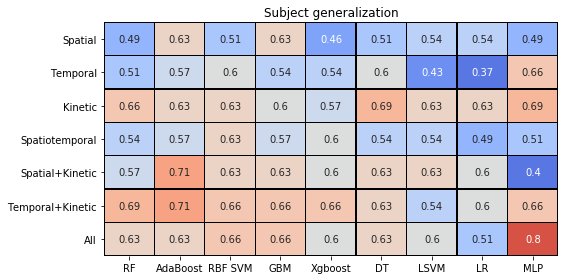

In [39]:
ml_model_names1 = ['RF','AdaBoost', 'RBF SVM', 'GBM','Xgboost', 'DT',  'LSVM', 'LR', 'MLP']
datasets = ['Spatial', 'Temporal', 'Kinetic', 'Spatiotemporal', 'Spatial+Kinetic', \
       'Temporal+Kinetic', 'All']

fig, axes = plt.subplots(1, 1, figsize=(8, 4))
sns.heatmap(person_accuracy_cohort_generlaize, vmin=0.4, vmax=0.85, center = 0.6, cmap="coolwarm", annot=True, linewidths=0.4, linecolor="k", \
            cbar = False, xticklabels=ml_model_names1,  yticklabels=datasets)
plt.title('Subject generalization')
plt.tight_layout()
plt.savefig(path + '..//viz//AblationStudy_cohort_generalize_heatmap.jpg', dpi = 250)
plt.show()